In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt

import torch
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset
import lightning as L
import pickle

from scipy.spatial.distance import cdist

import numpy as np
from deap import base
from deap import tools
from deap import creator
from deap.algorithms import eaSimple

In [2]:
features = ['Soil_Quality', 'Seed_Variety', 'Fertilizer_Amount_kg_per_hectare', 'Sunny_Days', 'Rainfall_mm', 'Irrigation_Schedule']
target = ['Yield_kg_per_hectare']

df_teste = pd.read_csv("agricultural_yield_test.csv")
df_treino = pd.read_csv("agricultural_yield_train.csv")

df_teste = df_teste.reindex(features + target, axis=1) 
df_teste = df_teste.dropna()

df_treino = df_treino.reindex(features + target, axis=1)
df_treino = df_treino.dropna()

In [3]:
df_teste

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,93.304721,0,132.522218,96.670922,602.386237,3,278.986563
1,83.674653,1,57.283997,99.007556,466.518251,8,836.434840
2,65.963033,1,227.895479,104.844272,510.320495,4,785.881787
3,78.692834,1,176.314126,90.136191,354.350914,5,807.884526
4,72.415684,1,160.070418,101.221668,443.993788,10,1064.542374
...,...,...,...,...,...,...,...
3995,95.094714,1,124.108262,98.970659,496.705800,5,802.209345
3996,53.256984,0,100.310322,111.448947,667.056391,8,509.646540
3997,94.145522,1,196.473704,110.003474,458.241408,3,776.013634
3998,61.452120,1,80.618357,97.815517,778.652540,4,502.319484


In [4]:
df_treino

,Soil_Quality,Seed_Variety,Fertilizer_Amount_kg_per_hectare,Sunny_Days,Rainfall_mm,Irrigation_Schedule,Yield_kg_per_hectare
0,96.415657,1,147.853040,94.593926,444.267569,3,683.759119
1,92.352626,0,281.565396,90.504644,517.585491,7,678.714861
2,63.714785,1,137.864940,97.329340,420.310945,8,934.691975
3,90.084256,1,100.946659,113.404828,547.817646,7,905.842541
4,81.600341,1,223.088908,83.048176,434.726333,6,897.584665
...,...,...,...,...,...,...,...
15995,77.053550,1,154.189768,103.115855,319.915079,7,956.781949
15996,99.795631,1,282.295839,123.598354,647.292136,4,879.682714
15997,67.478487,1,120.017122,102.308627,514.372747,8,932.829561
15998,85.176890,1,247.847389,114.956634,695.035801,6,889.738438


In [5]:
qualidade_solo = list(df_teste['Soil_Quality'])
variedade_semente = list(df_teste['Seed_Variety'])
fertilizante = list(df_teste['Fertilizer_Amount_kg_per_hectare'])
dias_de_sol = list(df_teste['Sunny_Days'])
chuva = list(df_teste['Rainfall_mm'])
irrigação = list(df_teste['Irrigation_Schedule'])

rendimento = list(df_teste['Yield_kg_per_hectare'])

In [6]:
lista = [qualidade_solo, variedade_semente, fertilizante, dias_de_sol, chuva, irrigação]

min_max = []

for i in lista:
    min_max.append(min(i))
    min_max.append(max(i))

print("Tamanho lista:", len(min_max)) # Deve ser 6 x 2
print(min_max)

Tamanho lista: 12
[50.00362248192461, 99.99889758903616, 0, 1, 50.06265491148749, 299.9920540908917, 66.72446890908668, 138.52020171941672, 102.0075178449252, 876.694216751489, 0, 15]


## Treinando a Rede Neural

Aqui ocorre o treinamento da melhor estrutura de rede encontrada com a otimização do optuna no "Projeto Final de Redes Neurais"

### Trabalhando com os dados para a rede

#### Definindo parâmetros

Os parâmetros a seguir serão utilizados posteriormente: 

In [7]:
TAMANHO_VALIDACAO = 0.1

SEMENTE_ALEATORIA = 61455

#### Separação do target

Agora é possível separar o target dos atributos que serão utilizados para prevê-lo. O target será a variável: `Yield_kg_per_hectare` (rendimento em quilos por hectare). 

*Lembrando:* O target é a variável que será prevista e, nesse caso, quantificada/estimada. 

In [8]:
X_teste = df_teste.reindex(features, axis=1).values
y_teste = df_teste.reindex(target, axis=1).values

X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

#### Split treino-validação

Para verificar se a o modelo criado é bom teremos que, posteriormente, comparar o rendimento predito pelo rendimento da validação. Desse modo, devemos realizar um split do conjunto de treino em subconjuntos: 1. de treino; 2. validação. 

In [9]:
indices = df_treino.index
print(indices, len(indices))
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_VALIDACAO, random_state=SEMENTE_ALEATORIA
)

print(indices_treino, len(indices_treino))
print()
print(indices_val, len(indices_val))

df_val = df_treino.loc[indices_val]
df_treino = df_treino.loc[indices_treino]


X_treino = df_treino.reindex(features, axis=1).values
y_treino = df_treino.reindex(target, axis=1).values

X_val = df_val.reindex(features, axis=1).values
y_val = df_val.reindex(target, axis=1).values

RangeIndex(start=0, stop=16000, step=1) 16000
Int64Index([ 2519, 11035,  3934, 14982,  4078, 12245, 12217,  9147, 11629,
             3768,
            ...
             6255,  7971, 13014,  6321, 12691,  2256, 10672,  6652, 11166,
            13937],
           dtype='int64', length=14400) 14400

Int64Index([ 8987,  4178,  4313,  1666,  6784, 12065, 10246,  8625,  9889,
             6176,
            ...
             4452, 12565, 12620, 13756, 14945,    97,  8368, 10148, 12993,
             5542],
           dtype='int64', length=1600) 1600


#### Normalização e transformação de dados

Nas células abaixo: 
1. Realizamos a normalização de dados por máximo absoluto, a fim de reduzir a dimensionalidade de cada um dos atributos. *É interessante lembrar que: as redes neurais trabalham melhor entre -1 e 1.* 

2. Transformamos os dados para treinar e testar a rede neural. A conversão dos dados de números para tensores é necessária pois o PyTorch trabalha somente com esse tipo de objeto. 

##### Normalização por máximo absoluto

In [10]:
x_scaler = MaxAbsScaler()
x_scaler.fit(X_treino)

y_scaler = MaxAbsScaler()
y_scaler.fit(y_treino)

X_treino = x_scaler.transform(X_treino)
y_treino = y_scaler.transform(y_treino)

X_val = x_scaler.transform(X_val)
y_val = y_scaler.transform(y_val)

X_teste = x_scaler.transform(X_teste)
y_teste = y_scaler.transform(y_teste)

##### Conversão para tensores

In [11]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

###### Tensores de teste

In [12]:
X_teste

tensor([[0.9331, 0.0000, 0.4418, 0.6788, 0.6905, 0.2000],
        [0.8368, 1.0000, 0.1910, 0.6952, 0.5348, 0.5333],
        [0.6596, 1.0000, 0.7597, 0.7362, 0.5850, 0.2667],
        ...,
        [0.9415, 1.0000, 0.6549, 0.7724, 0.5253, 0.2000],
        [0.6145, 1.0000, 0.2687, 0.6868, 0.8926, 0.2667],
        [0.5520, 0.0000, 0.4083, 0.6341, 0.6683, 0.2667]])

In [13]:
y_teste

tensor([[0.2014],
        [0.6039],
        [0.5674],
        ...,
        [0.5603],
        [0.3627],
        [0.1856]])

###### Tensores de treino

In [14]:
X_treino

tensor([[0.9795, 0.0000, 0.7640, 0.7867, 0.4237, 0.2000],
        [0.9797, 0.0000, 0.9775, 0.5857, 0.6576, 0.2667],
        [0.9986, 1.0000, 0.4590, 0.6481, 0.5381, 0.1333],
        ...,
        [0.6414, 1.0000, 0.9437, 0.7126, 0.5219, 0.3333],
        [0.6388, 1.0000, 0.4695, 0.6392, 0.3804, 0.2667],
        [0.9902, 1.0000, 0.5284, 0.7755, 0.6688, 0.3333]])

In [15]:
y_treino

tensor([[0.3213],
        [0.3385],
        [0.4438],
        ...,
        [0.6514],
        [0.4705],
        [0.5933]])

In [16]:
y_scaler.inverse_transform(y_treino[1].reshape(-1, 1))

array([[468.82317328]])

###### Tensores de validação 

In [17]:
X_val

tensor([[0.6182, 1.0000, 0.3226, 0.7208, 0.6738, 0.5333],
        [0.9165, 0.0000, 0.1888, 0.6953, 0.4263, 0.0667],
        [0.6729, 1.0000, 0.5926, 0.7751, 0.6263, 0.2667],
        ...,
        [0.7481, 1.0000, 0.2723, 0.6990, 0.4905, 0.4667],
        [0.5995, 1.0000, 0.7954, 0.6793, 0.6092, 0.5333],
        [0.5068, 1.0000, 0.8737, 0.7273, 0.5378, 0.5333]])

In [18]:
y_val

tensor([[0.6336],
        [0.1526],
        [0.5981],
        ...,
        [0.5879],
        [0.7066],
        [0.6803]])

### Criando e treinando a rede

Esta célula é o passo inicial para criarmos e treinarmos nosso modelo. Utiliza a classe mãe, o `DataModule` do `Lightning`, que encapsula diversas informações necessárias para preparar nossos dados e futuramente usar o `Lightning` no treinamento.

Obs: o número de trabalhadores foi selecionado como 8, pois o código foi trabalhado em um computador de alto desempenho (HPC).

In [19]:
class DataModule(L.LightningDataModule):
    def __init__(
        self,
        X_treino,
        y_treino,
        X_val,
        y_val,
        X_teste,
        y_teste,
        tamanho_lote = 256,
        num_trabalhadores = 2,
    ):
        super().__init__()

        self.tamanho_lote = tamanho_lote
        self.num_trabalhadores = num_trabalhadores

        self.X_treino = X_treino
        self.y_treino = y_treino
        self.X_val = X_val
        self.y_val = y_val
        self.X_teste = X_teste
        self.y_teste = y_teste

    def train_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_treino, self.y_treino),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def val_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_val, self.y_val),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

    def test_dataloader(self):
        return DataLoader(
            TensorDataset(self.X_teste, self.y_teste),
            batch_size=self.tamanho_lote,
            num_workers=self.num_trabalhadores,
            persistent_workers=True
        )

Para verificar se os dados estavam devidamente tratados e se funcionariam em nossa MLP (Multilayer Perceptron), criamos uma MLP de teste com arquitetura aleatória. Veja:  

In [20]:
class MLP(L.LightningModule):
    def __init__(
        self, num_dados_entrada, num_targets, neuronios, dropouts
    ):
        super().__init__()    
        
        camadas = []   
        
        neuronios = [num_dados_entrada]+neuronios
    
        for k in range(len(neuronios)-1): # Camada de entrada + camadas ocultas 
            camadas.append(nn.Linear(neuronios[k], neuronios[k+1]))
            camadas.append(nn.ReLU())
            camadas.append(nn.Dropout(dropouts[k]))
        
        camadas.append(nn.Linear(neuronios[-1], num_targets)) # Camada de saída
        
        self.camadas = nn.Sequential(*camadas) 
        

        self.fun_perda = F.mse_loss

        self.perdas_treino = []
        self.perdas_val = []

        self.curva_aprendizado_treino = []
        self.curva_aprendizado_val = []

    def forward(self, x):
        x = self.camadas(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("loss", loss, prog_bar=True)
        self.perdas_treino.append(loss)

        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("val_loss", loss, prog_bar=True)
        self.perdas_val.append(loss)

        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self(x)
        loss = self.fun_perda(y, y_pred)

        self.log("test_loss", loss)

        return loss

    def on_train_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_treino).mean()
        self.curva_aprendizado_treino.append(float(perda_media))
        self.perdas_treino.clear()

    def on_validation_epoch_end(self):
        # Atualiza curva de aprendizado
        perda_media = torch.stack(self.perdas_val).mean()
        self.curva_aprendizado_val.append(float(perda_media))
        self.perdas_val.clear()

    def configure_optimizers(self):
        optimizer = optim.SGD(self.parameters(), lr=1e-3)
        return optimizer

Caracterítiscas da melhor MLP encontrada pela otimização: 
1. Camada de entrada com 6 neurônios 
2. Função de ativação: ReLU (obs: não foi um hiperparâmetro)
3. Taxa de Dropout de aprox. 27,34% 
4. Camada oculta com 117 neurônios 
5. Camada de saída com 1 neurônio

In [21]:
num_dados_entrada = 6
num_targets = 1
neuronios = [117]
dropouts = [0.2734006184484247]

In [22]:
datamodule = DataModule(X_treino, y_treino, X_val, y_val, X_teste, y_teste)

In [23]:
# Criar o modelo com os parâmetros do melhor teste
melhor_modelo = MLP(num_dados_entrada, num_targets, neuronios, dropouts)

melhor_modelo.train()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=117, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2734006184484247, inplace=False)
    (3): Linear(in_features=117, out_features=1, bias=True)
  )
)

In [24]:
# Treinar o modelo com o Trainer
MAX_EPOCHS = 400

early_stop_callback = EarlyStopping(monitor="val_loss", mode="min", patience=3)
treinador= L.Trainer(max_epochs=MAX_EPOCHS, callbacks=[early_stop_callback], enable_progress_bar=False) 
treinador.fit(melhor_modelo, datamodule=datamodule)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name    | Type       | Params
---------------------------------------
0 | camadas | Sequential | 937   
---------------------------------------
937       Trainable params
0         Non-trainable params
937       Total params
0.004     Total estimated model params size (MB)
`Trainer.fit` stopped: `max_epochs=400` reached.


In [25]:
nome_arquivo = "meu_modelo.p"
pickle.dump(melhor_modelo.state_dict(), open(nome_arquivo, "wb"))

In [26]:
melhor_modelo.eval()

MLP(
  (camadas): Sequential(
    (0): Linear(in_features=6, out_features=117, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2734006184484247, inplace=False)
    (3): Linear(in_features=117, out_features=1, bias=True)
  )
)

Vamos testar se funciona.

In [27]:
datamodule.setup("test")

with torch.no_grad():
    X_true = datamodule.X_teste
    
    y_true = datamodule.y_teste
    y_true = y_scaler.inverse_transform(y_true)

    y_pred = melhor_modelo(X_true)
    y_pred = y_scaler.inverse_transform(y_pred)

    RMSE = mean_squared_error(y_true, y_pred, squared=False)

    print(RMSE)

68.77206129211164


Text(0, 0.5, 'Loss')

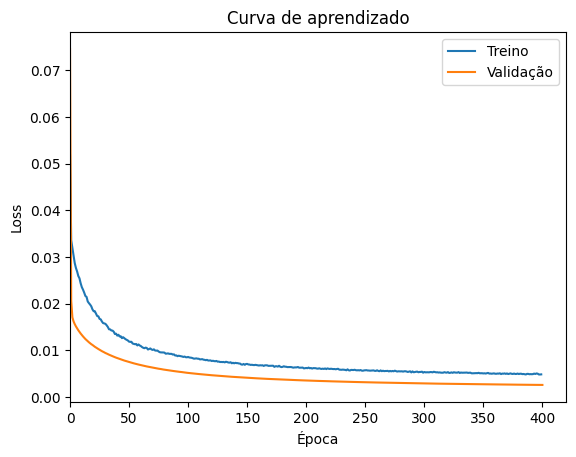

In [28]:
# Plot treino e validação
    
figura, eixo = plt.subplots()

ca_treino_melhor_modelo = melhor_modelo.curva_aprendizado_treino
ca_val_melhor_modelo = melhor_modelo.curva_aprendizado_val

eixo.plot(ca_treino_melhor_modelo, label="Treino")
eixo.plot(ca_val_melhor_modelo, label="Validação")

eixo.legend()

eixo.set_xlim(left=0)

eixo.set_title("Curva de aprendizado")
eixo.set_xlabel("Época")
eixo.set_ylabel("Loss")

### Usando módulo DEAP para algoritmo genético

In [29]:
TAMANHO_POPULACAO = 100
NUM_GERACOES = 150
CHANCE_DE_CRUZAMENTO = 0.5
CHANCE_DE_MUTACAO = 0.5
TAMANHO_TORNEIO = 5
TAMANHO_HALL_DA_FAMA = 1

In [30]:
toolbox = base.Toolbox()

In [31]:
i = 0
j = 0

for _ in range(6):
    print(features[i], '-> Min =', min_max[j], '/ Max =', min_max[j+1])
    print()
    i += 1
    j += 2

Soil_Quality -> Min = 50.00362248192461 / Max = 99.99889758903616

Seed_Variety -> Min = 0 / Max = 1

Fertilizer_Amount_kg_per_hectare -> Min = 50.06265491148749 / Max = 299.9920540908917

Sunny_Days -> Min = 66.72446890908668 / Max = 138.52020171941672

Rainfall_mm -> Min = 102.0075178449252 / Max = 876.694216751489

Irrigation_Schedule -> Min = 0 / Max = 15



In [32]:
print(min_max)

[50.00362248192461, 99.99889758903616, 0, 1, 50.06265491148749, 299.9920540908917, 66.72446890908668, 138.52020171941672, 102.0075178449252, 876.694216751489, 0, 15]


In [33]:
def gene_soil_quality():
    return random.uniform(min_max[0], min_max[1])

def gene_seed_variety():
    return random.choice([min_max[2], min_max[3]])

def gene_fertilizer_amount():
    return random.uniform(min_max[4], min_max[5])

def gene_sunny_days():
    return random.uniform(min_max[6], min_max[7])

def gene_rainfall():
    return random.uniform(min_max[8], min_max[9])

def gene_irrigation_schedule():
    return random.randint(int(min_max[10]), int(min_max[11]))

Registrando os genes no toolbox

In [34]:
toolbox.register("gene_soil_quality", gene_soil_quality)
toolbox.register("gene_seed_variety", gene_seed_variety)
toolbox.register("gene_fertilizer_amount", gene_fertilizer_amount)
toolbox.register("gene_sunny_days", gene_sunny_days)
toolbox.register("gene_rainfall", gene_rainfall)
toolbox.register("gene_irrigation_schedule", gene_irrigation_schedule)

In [35]:
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individuo", list, fitness=creator.FitnessMax)

In [36]:
def cria_individuo():
    return creator.Individuo([
        toolbox.gene_soil_quality(),
        toolbox.gene_seed_variety(),
        toolbox.gene_fertilizer_amount(),
        toolbox.gene_sunny_days(),
        toolbox.gene_rainfall(),
        toolbox.gene_irrigation_schedule()
    ])

In [37]:
individuo_teste = cria_individuo()

print(individuo_teste)

[56.11895092172438, 1, 258.68195836780774, 129.81791842013277, 433.7579189330817, 9]


In [38]:
num = max(rendimento)

indice = rendimento.index(num)

linha = indice
individuo = df_treino.iloc[linha,:-1].values

print(individuo)
print(rendimento[indice])

[ 96.54837663   0.         107.98822288  98.04618594 450.36612122
   4.        ]
1406.1107054578508


In [39]:
individuo = torch.tensor(individuo, dtype=torch.float32)

# Realizar a predição
with torch.no_grad():
    y_pred = melhor_modelo(individuo).reshape(-1, 1)
    y_pred = y_scaler.inverse_transform(y_pred)

print(y_pred[0][0])

1623.4603713656602


Criando e testando a função objetivo

In [40]:
def funcao_objetivo(individuo):
    """Computa a função objetivo prevendo o valor de y_pred e tentando maximizá-lo."""
    
    individuo = torch.tensor(individuo, dtype=torch.float32).unsqueeze(0)  # Adicionar dimensão de batch

    
    # Realizar a predição
    with torch.no_grad():
        y_pred = melhor_modelo(individuo)
        y_pred = y_scaler.inverse_transform(y_pred.reshape(-1, 1))
        
    # Calcular a distância de Manhattan entre y_pred e todos os valores de y_true definidos anteriormente
    y_pred_val = y_pred[0][0]
    y_true_vals = y_true.reshape(-1, 1)
    distances = cdist([[y_pred_val]], y_true_vals, metric='cityblock')
    
    # Verificar a menor distância
    min_distance = distances.min()
    if min_distance > 500:
        y_pred_val = 0
    

    return(y_pred_val, )

In [42]:
funcao_objetivo(individuo)

C:\Users\joao23022\AppData\Local\Temp\ipykernel_14868\2900109287.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  individuo = torch.tensor(individuo, dtype=torch.float32).unsqueeze(0)  # Adicionar dimensão de batch


(1623.4603713656602,)

In [43]:
def mutacao_personalizada(individuo, chance_de_mutacao, min_max_list):
    
    min_max = min_max_list
        
    for gene in range(len(individuo)):
        if random.random() < chance_de_mutacao:
            if gene == 0:
                individuo[gene] = random.uniform(min_max[0], min_max[1])
            elif gene == 1:
                individuo[gene] = 0 if individuo[gene] == 1 else 1
            elif gene == 2:
                individuo[gene] = random.uniform(min_max[4], min_max[5])
            elif gene == 3:
                individuo[gene] = random.uniform(min_max[6], min_max[7])
            elif gene == 4:
                individuo[gene] = random.uniform(min_max[8], min_max[9])
            elif gene == 5:
                individuo[gene] = random.randint(int(min_max[10]), int(min_max[11]))
        
    return (individuo, )

In [44]:
toolbox.register("evaluate", funcao_objetivo)

In [45]:
toolbox.register("cria_individuo", cria_individuo)
toolbox.register("populacao", tools.initRepeat, list, toolbox.cria_individuo, TAMANHO_POPULACAO)
toolbox.register("select", tools.selTournament, tournsize=TAMANHO_TORNEIO)
toolbox.register("mate", tools.cxUniform, indpb=0.5)

toolbox.register(
    "mutate",
    mutacao_personalizada,
    chance_de_mutacao = CHANCE_DE_MUTACAO,
    min_max_list = min_max
)

hall_da_fama = tools.HallOfFame(TAMANHO_HALL_DA_FAMA)

estatisticas = tools.Statistics(lambda ind: ind.fitness.values)
estatisticas.register("média", np.mean)
estatisticas.register("desv. padrão", np.std)
estatisticas.register("min", np.min)
estatisticas.register("max", np.max)

populacao_inicial = toolbox.populacao()

In [46]:
populacao_final, log = eaSimple(
    populacao_inicial,
    toolbox,
    cxpb=CHANCE_DE_CRUZAMENTO,
    mutpb=CHANCE_DE_MUTACAO,
    ngen=NUM_GERACOES,
    stats=estatisticas,
    halloffame=hall_da_fama,
    verbose=True,
)

gen	nevals	média  	desv. padrão	min     	max    
0  	100   	41.2504	193.12      	-261.703	1273.05
1  	69    	152.946	393.364     	-205.602	1866.58
2  	86    	305.94 	581.164     	-239.867	1866.58
3  	73    	513.042	703.57      	-342.733	1894.04
4  	81    	648.512	762.032     	-254.154	1895.69
5  	82    	585.944	790.678     	-268.54 	1899.84
6  	70    	840.608	837.292     	-275.684	1895.69
7  	77    	734.457	876.972     	-331.461	1895.69
8  	68    	920.9  	891.467     	-257.837	1895.69
9  	64    	940.241	912.892     	-340.314	1895.69
10 	77    	914.011	901.399     	-317.886	1895.69
11 	75    	733.503	882.323     	-341.003	1895.69
12 	71    	871.958	919.075     	-385.76 	1895.69
13 	84    	870.221	915.942     	-268.54 	1895.69
14 	70    	931.034	925.301     	-361.601	1895.69
15 	73    	1084.66	909.789     	-250.779	1895.69
16 	72    	1048.46	910.429     	-205.286	1895.69
17 	69    	1108.99	906.292     	-96.2717	1895.69
18 	84    	926.037	932.539     	-376.677	1895.69
19 	74    	1107.74	8

In [48]:
print(hall_da_fama.items[0])

[53.50845644515552, 0, 68.65328665253034, 107.79096753047125, 710.4793681983692, 10]


In [47]:
individuo = torch.tensor(hall_da_fama.items[0])

# Realizar a predição
with torch.no_grad():
    y_pred = melhor_modelo(individuo).reshape(-1, 1)
    y_pred = y_scaler.inverse_transform(y_pred)

print(f"A previsão máxima de rendimento encontrada foi: {y_pred[0][0]}")

A previsão máxima de rendimento encontrada foi: 1905.6691964314996
